In [1]:
import sys
sys.path.append('..')

In [23]:
from src.preprocessing import *
from sklearn.model_selection import ValidationCurveDisplay
from sklearn.feature_selection import RFECV, RFE
import src.config as config
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [60]:
import talib as ta
import sklearn.tree as tree
import sklearn.metrics as metrics
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import KernelPCA, PCA

In [4]:
df = pd.read_csv('../data/data.csv')
X, y = prep_data(df, config.LAGS, config.FUTURE_PRED, config.MULTIPLIER_FOR_DESIRED_POS)

Generating desired position...
Desired position generated
Generating original features...
Generating momentum features...
Generating math features...
Generating pattern features...
Generating time features...
All features generated
Splitting features/target
Features/target split complete


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [61]:
pipe = make_pipeline(
    PCA(),
    RandomForestClassifier(),
)

In [62]:
params = {
    'pca__n_components': [i for i in range(1, 20)],
    'randomforestclassifier__n_estimators': [i for i in range(100, 2000, 100)],
    'randomforestclassifier__max_depth': [None, 5, 10, 20],
    'randomforestclassifier__min_samples_split': [i for i in range(1, 20000, 1000)],
    'randomforestclassifier__min_samples_leaf': [i for i in range(1, 20000, 1000)],
    'randomforestclassifier__warm_start': [True],
}

In [63]:
search = RandomizedSearchCV(
    pipe,
    params,
    n_iter=100,
    n_jobs=-1,
    verbose=3,
    cv=5,
    scoring='accuracy',
    random_state=42,
)

In [67]:
pipe.fit(X_train, y_train['pos_change_signal'])

In [43]:
dim_reduction = PCA(n_components=10)

In [44]:
X_trainsformed = dim_reduction.fit_transform(X_train)

In [59]:
clf = RandomForestClassifier()
clf.fit(X_trainsformed, y_train['pos_change_signal'])
clf.score(dim_reduction.transform(X_test), y_test['pos_change_signal'])

0.34295695735284426

In [52]:
dim_reduction.get_feature_names_out()

array(['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7',
       'pca8', 'pca9'], dtype=object)

In [32]:
y_train.columns

Index(['pos_change_signal', 'net_pos_signal', 'desired_pos_change',
       'desired_pos_rolling'],
      dtype='object')

<AxesSubplot:>

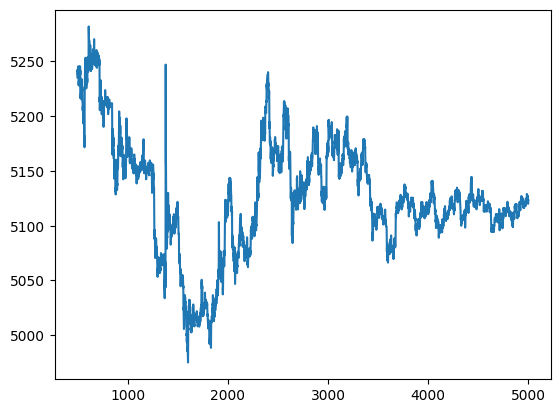

In [39]:
df.close[500:5000].plot()

<AxesSubplot:>

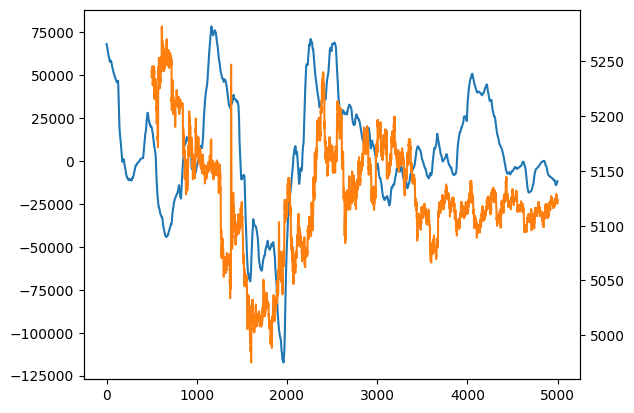

In [42]:
plt.plot(X_trainsformed[:5000])
df.close[500:5000].plot(secondary_y=True)

In [18]:
feature_selector = SelectKBest(mutual_info_classif, k=10)

In [9]:
feature_selector = RFE(
    DecisionTreeClassifier(max_depth=10),
    step=10,
    verbose=3,
)

In [11]:
X_transformed = feature_selector.fit_transform(X_train, y_train['pos_change_signal'])

Fitting estimator with 581 features.


In [20]:
feature_selector.get_feature_names_out()

array(['APO_7', 'CCI_17', 'CMO_7', 'LINEARREG_ANGLE_17',
       'LINEARREG_SLOPE_17', 'MACDSIGNAL_7', 'MOM_7', 'PPO_7', 'ROC_7',
       'RSI_7'], dtype=object)

In [45]:
ValidationCurveDisplay.from_estimator(
    clf, X, y['pos_change_signal'], param_name='max_depth', param_range=[i for i in range(1, 50, 5)], scoring='accuracy'
)

In [ ]:
clf = RandomForestClassifier(n_estimators=1000, min_samples_split=10000)

In [ ]:
X_train

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
print(metrics.classification_report(y_test, clf.predict(X_test)))

In [ ]:
df = pd.read_csv("../data/data.csv")

In [ ]:
df = prepare_desired_pos(df, 10, 10)

In [ ]:
df.desired_pos_change.plot()

In [ ]:
df[['pos_change_signal', 'net_pos_signal']].value_counts().plot(kind='pie')

In [ ]:
rle(df, True)

In [ ]:
df['daily_pnl'] = df['desired_pos_rolling'] * (df['close'] - df['open'])

In [ ]:
df.daily_pnl.cumsum().plot()

In [ ]:
output = ta_map["SMA"](inputs)

In [ ]:
output

In [ ]:
ta.RSI.parameters

In [ ]:
from talib import abstract

abstract.SMA.parameters

In [ ]:
df = pd.read_csv("data.csv")

In [ ]:
generate_time_features(df)

In [ ]:
df.datetime

In [ ]:
with open("feature_names.txt", "r") as f:
    features = f.read()

In [ ]:
import re

# Save this for production use!

In [ ]:
with open("feature_names.txt", "r") as f:
    features = f.read()
feats = re.findall(r"(\w+\D)(\d+\b)", features)
func_pool = []

In [ ]:
for func in feats:
    if func[0] == "MACDHIST" or func[0] == "MACDSIGNAL":
        continue
    if func[0] == "MACDSIGNALFIX" or func[0] == "MACDHISTFIX":
        continue
    if func[0] == "STOCHRSI_k" or func[0] == "STOCHRSI_d":
        continue
    if func[0] == "HT_PHASORinphase" or func[0] == "HT_PHASORquadrature":
        func[0] = "HT_PHASOR"
    if func[0] == "HT_SINEsine" or func[0] == "HT_SINEleadsine":
        func[0] = "HT_SINE"
    function = getattr(ta, func[0])
    func_pool.append((function, int(func[1])))

In [ ]:
inspect.signature(func_pool[0][0])

In [ ]:
import inspect

In [ ]:
for func, lag in func_pool:
    parameters = inspect.signature(func).parameters

In [ ]:
import talib as ta

In [ ]:
getattr(ta, feats[0][0])